# Analyse Random Number Generation

* Check for duplicates
* Check number distributions
    

In [10]:
import numpy as np
import os
import subprocess


def get_random_numbers(dir:str, settings: str, type):

    with open('settings', mode='w') as fid:
        fid.write(settings)
    
    result = subprocess.run([f'./{dir}/test_xor'], capture_output=True, check=True, encoding="utf-8")
        
    os.remove('settings')
    
    # Parse result into numpy, avoiding last line, which is blank
    random_values = np.empty(shape=n_random, dtype=type)
    for i, line in enumerate(result.stdout.split('\n')[:-1]):
        random_values[i] = type(line.split()[-1])
        
    return random_values
        


In [11]:
""" Clearly fine due to the floating point precision, allowing for small differences in two reals.
"""
build_dir = 'cmake-build'

# Real64 tests
n_random = 10000

for r_max in [10., 100., 1000.]:
    # Dump then remove
    settings = f"""real64
    {n_random}
    1 {r_max}
    """
    
    random_reals = get_random_numbers(build_dir, settings, float)
    
    # Check unique values
    print(f'Range [1, {r_max}]. Number of unique values {np.unique(random_reals).shape} / {n_random}')


Range [1, 10.0]. Number of unique values (10000,) / 10000
Range [1, 100.0]. Number of unique values (10000,) / 10000
Range [1, 1000.0]. Number of unique values (10000,) / 10000


In [13]:
""" Even with a normal distribution of pseudo-random numbers and i_max - i_min >> total number of random 
numbers asked for (by an order of magnitude), I am still getting ~ 10% of the return values as duplicates.
"""
# Integer tests
n_random = 10000

i_max_values = [10, 100, 1000, 2000, 5000, 10000, 100000]

for i_max in i_max_values:
    # Dump then remove
    settings = f"""int32
    {n_random}
    1 {i_max}
    """
    
    random_integers = get_random_numbers(build_dir, settings, int)
    
    # Check unique values
    print(f'Range [1, {i_max}]. Number of unique values {np.unique(random_integers).shape} / {n_random}')


Range [1, 10]. Number of unique values (5,) / 10000
Range [1, 100]. Number of unique values (50,) / 10000
Range [1, 1000]. Number of unique values (500,) / 10000
Range [1, 2000]. Number of unique values (1000,) / 10000
Range [1, 5000]. Number of unique values (2460,) / 10000
Range [1, 10000]. Number of unique values (4328,) / 10000
Range [1, 100000]. Number of unique values (9042,) / 10000


In [61]:
""" Simple Reservoir Sampling

Testing the value distribution.
* Generate a set of numbers k times. 
* Plot the distribution of the number repetition.
"""

n_sample = 100
period = 1000
repeats = {str(i): 0 for i in range(0, period + 1)}

n_repeats = 1000

for i in range(n_repeats):
    result = subprocess.run([f'./{build_dir}/simple_reservoir', str(n_sample), str(period)], capture_output=True, check=True, encoding="utf-8")
    for value in result.stdout.split():
        repeats[str(value)] += 1


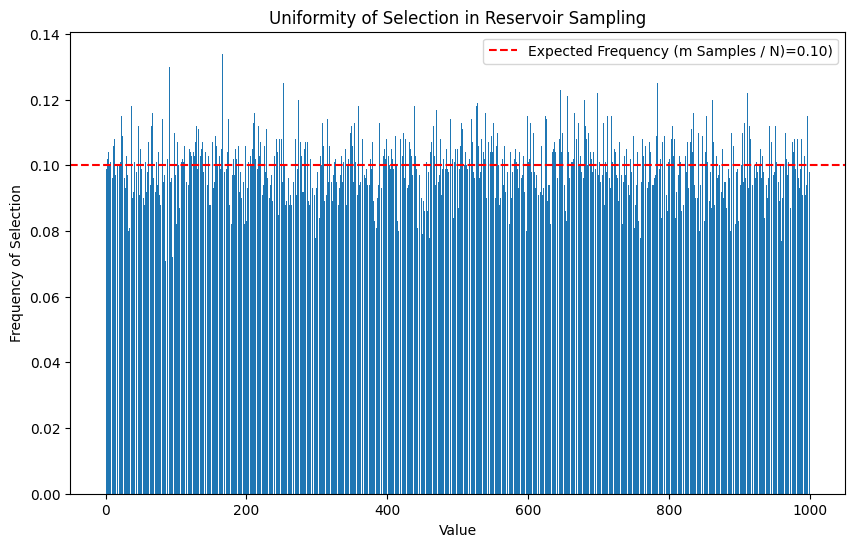

In [62]:
import matplotlib.pyplot as plt

# Plot distribution
frequency = np.empty(shape=(period+1))
for i in range(0, period+1):
    frequency[i] = repeats[str(i)]
    
expected_frequency = (n_sample / period)    

plt.figure(figsize=(10, 6))
plt.bar(range(0, period + 1), frequency / n_repeats)
plt.xlabel('Value')
plt.ylabel('Frequency of Selection')
plt.title(f'Uniformity of Selection in Reservoir Sampling')
plt.axhline(y=expected_frequency, color='r', linestyle='--', label=f'Expected Frequency (m Samples / N)={expected_frequency:.2f})') 
plt.legend()
plt.show()


In [63]:
from scipy.stats import chisquare

print("Top 10 repeated numbers:")
indices = np.argsort(-frequency)
for i in range(0, 10):
    i_new = indices[i]
    print(i_new, frequency[i_new] / n_repeats)

print("Average frequency and expected frequency:")
print(np.mean(frequency)/ n_repeats, expected_frequency)

# Chi-SquareStatistics gives a ValueError
# expected_frequencies = np.full(period + 1, expected_frequency)
# observed_frequencies = frequency / n_repeats
# chisqr = chisquare(observed_frequencies, f_exp=expected_frequencies)
# print(f"Chi-Square Statistic: {chisqr.statistic}")
# print(f"P-Value: {chisqr.pvalue}")
# One might also consider doing Anderson-Darling Test: 
# Provides a measure of how well the observed data fits the uniform distribution.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html


Top 10 repeated numbers:
166 0.134
715 0.131
91 0.13
62 0.129
26 0.128
784 0.125
253 0.125
488 0.124
646 0.123
748 0.123
Average frequency and expected frequency:
0.0999000999000999 0.1


In [81]:
""" Hidden-Shuffle Sampling

Same test as above.

Testing the value distribution.
* Generate a set of numbers k times. 
* Plot the distribution of the number repetition.
"""

n_sample = 100
period = 1000
n_repeats = 500
repeats = {str(i): 0 for i in range(0, period + 1)}

for i in range(n_repeats):
#for i in range(n_repeats):
    result = subprocess.run([f'./{build_dir}/hidden_shuffle', str(n_sample), str(period)], capture_output=True, check=True, encoding="utf-8")
    values = result.stdout.split()
    print(i, values[:5])
    for value in values:
        repeats[str(value)] += 1


0 ['8', '16', '22', '28', '33']
1 ['12', '28', '33', '40', '41']
2 ['12', '18', '29', '37', '48']
3 ['12', '14', '29', '53', '64']
4 ['0', '1', '2', '15', '17']
5 ['8', '14', '21', '32', '47']
6 ['1', '10', '45', '49', '61']
7 ['2', '11', '12', '43', '47']
8 ['5', '23', '24', '27', '33']
9 ['12', '14', '31', '41', '55']
10 ['7', '13', '14', '17', '23']
11 ['0', '10', '14', '29', '43']
12 ['4', '6', '15', '40', '43']
13 ['16', '23', '28', '32', '52']
14 ['1', '7', '19', '20', '25']
15 ['2', '7', '9', '19', '20']
16 ['16', '39', '41', '46', '48']
17 ['2', '3', '5', '42', '46']
18 ['3', '14', '21', '49', '70']
19 ['1', '37', '62', '68', '89']
20 ['0', '17', '20', '22', '38']
21 ['7', '10', '25', '41', '52']
22 ['29', '33', '34', '39', '47']
23 ['36', '54', '56', '58', '63']
24 ['9', '14', '17', '26', '29']
25 ['11', '12', '14', '57', '64']
26 ['10', '14', '28', '38', '41']
27 ['7', '12', '15', '29', '33']
28 ['15', '21', '27', '32', '64']
29 ['0', '19', '21', '25', '28']
30 ['5', '14', '2

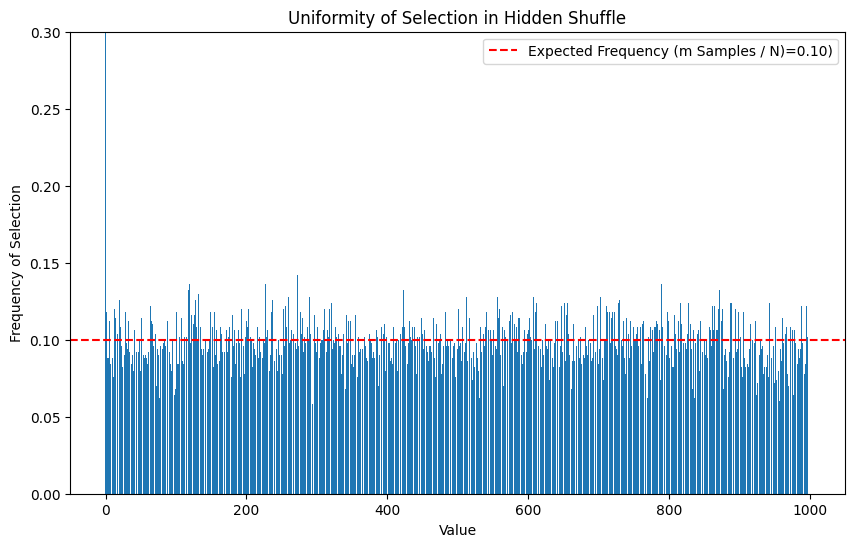

Top 10 repeated numbers:
0 0.896
998 0.256
701 0.144
273 0.142
448 0.14
790 0.136
227 0.136
119 0.136
522 0.134
872 0.132
Average frequency and expected frequency:
0.099104 0.1
This looks very good if 0 is excluded


In [82]:
# Plot distribution

expected_frequency = (n_sample / period)    
frequency = np.empty(shape=(period+1))
for i in range(0, period+1):
    frequency[i] = repeats[str(i)]
    
plt.figure(figsize=(10, 6))
plt.bar(range(0, period + 1), frequency / n_repeats)
plt.xlabel('Value')
plt.ylim([0, 0.3])
plt.ylabel('Frequency of Selection')
plt.title(f'Uniformity of Selection in Hidden Shuffle')
plt.axhline(y=expected_frequency, color='r', linestyle='--', label=f'Expected Frequency (m Samples / N)={expected_frequency:.2f})') 
plt.legend()
plt.show()

print("Top 10 repeated numbers:")
indices = np.argsort(-frequency)
for i in range(0, 10):
    i_new = indices[i]
    print(i_new, frequency[i_new] / n_repeats)

print("Average frequency and expected frequency:")
print(np.mean(frequency[1:])/ n_repeats, expected_frequency)
print('This looks very good if 0 is excluded')

N Samples, Period
32.0 1000
71.0 5000
100.0 10000
224.0 50000
316.0 100000
707.0 500000
1000.0 1000000


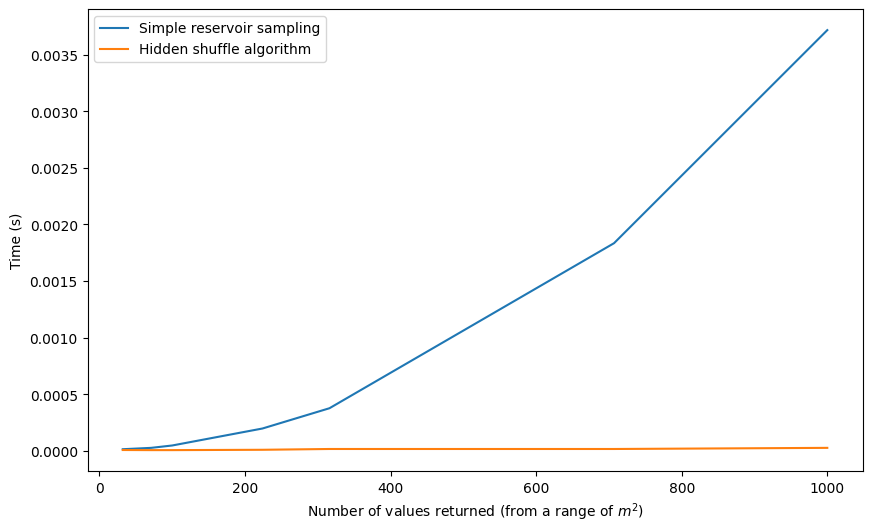

In [80]:
""" Simple Reservoir Timings vs Hidden Shuffle Timings

* Plot m = sqrt(n) vs time.
"""

periods = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]

print('N Samples, Period')

timings = np.empty(shape=(len(periods), 3))
for i, period in enumerate(periods):
    
    n_sample = np.round(np.sqrt(period))
    timings[i, 0] = n_sample
    print(n_sample, period)

    # Reservoir
    result = subprocess.run([f'./{build_dir}/simple_reservoir', str(int(n_sample)), str(period)], capture_output=True, check=True, encoding="utf-8")
    values = np.asarray(result.stdout.split())
    assert np.unique(values).shape == values.shape, "Replacements in simple reservoir found (erroneous)"
    with open(file='rs_timing.dat', mode='r') as fid:
        time = eval(fid.read())
    timings[i, 1] = time

    # Hidden shuffle
    result = subprocess.run([f'./{build_dir}/hidden_shuffle', str(int(n_sample)), str(period)], capture_output=True, check=True, encoding="utf-8")
    values = np.asarray(result.stdout.split())
    if np.unique(values).shape != values.shape:
        # erroneous_values = np.unique(values, return_counts=True) 
        raise ValueError("Replacements in hidden shuffle found (erroneous)")
    with open(file='hs_timing.dat', mode='r') as fid:
        time = eval(fid.read())
    timings[i, 2] = time
    

plt.figure(figsize=(10, 6))
plt.plot(timings[:, 0], timings[:, 1], label='Simple reservoir sampling')
plt.plot(timings[:, 0], timings[:, 2], label='Hidden shuffle algorithm')
plt.xlabel(r'Number of values returned (from a range of $m^2$)')
plt.ylabel('Time (s)')
plt.legend()
plt.show()
